[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\HP\AppData\Local\Temp\ipykernel_28072\1115690220.py:20: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\HP\Downloads\archive\US_comments_Cleaned.csv")
C:\Users\HP\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HP\anaconda3\Lib\site-packages\joblib\external

n_clusters=2, Score=0.1671
n_clusters=3, Score=-0.0092
n_clusters=4, Score=0.0064
n_clusters=5, Score=0.0076
n_clusters=6, Score=0.0114
n_clusters=7, Score=0.0144
n_clusters=8, Score=0.1119
n_clusters=9, Score=0.1140

Meilleur n_clusters: 2, Score Silhouette: 0.1671


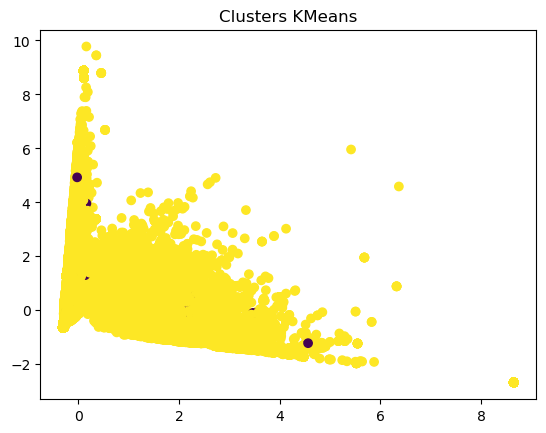

Tous les composants ont été enregistrés dans C:\Users\HP\PycharmProjects\djangoProject\clusterning\ia


In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump
import os

# Configuration initiale
nltk.download(['stopwords', 'wordnet'])

# Préparation des données
data = pd.read_csv(r"C:\Users\HP\Downloads\archive\US_comments_Cleaned.csv")
data = data.sample(frac=0.3, random_state=42)
data_clean = data[['comment_text']].copy()

# Fonction de prétraitement
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Suppression des caractères spéciaux
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and len(word) > 3]
    return ' '.join(tokens) if tokens else ''

# Appliquer le prétraitement
data_clean['cleaned_text'] = data_clean['comment_text'].fillna("").apply(preprocess_text)

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=7000, min_df=3, max_df=0.85, ngram_range=(1, 2), sublinear_tf=True)
tfidf_matrix = vectorizer.fit_transform(data_clean['cleaned_text'])

# Réduction de dimension avec SVD
svd = TruncatedSVD(n_components=150, random_state=42)
reduced_data = svd.fit_transform(tfidf_matrix)

# Normalisation
scaler = StandardScaler()
reduced_data = scaler.fit_transform(reduced_data)

# Trouver le meilleur nombre de clusters
best_score = -1
best_n_clusters = None
n_clusters_values = range(2, 10)

for n_clusters in n_clusters_values:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(reduced_data)
    
    score = silhouette_score(reduced_data, labels)
    print(f"n_clusters={n_clusters}, Score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

# ... (le reste de votre code reste inchangé)

# Après avoir trouvé le meilleur nombre de clusters et entraîné le modèle final :
if best_n_clusters is not None:
    print(f"\nMeilleur n_clusters: {best_n_clusters}, Score Silhouette: {best_score:.4f}")
    
    # Entraînement final avec le meilleur nombre de clusters
    kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
    labels_kmeans = kmeans.fit_predict(reduced_data)
    
    # Visualisation des clusters
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_kmeans, cmap="viridis")
    plt.title("Clusters KMeans")
    plt.show()
     
    # Créer les dossiers clusterning et ia s'ils n'existent pas
    model_dir = r'C:\Users\HP\PycharmProjects\djangoProject\clusterning\ia'
    os.makedirs(model_dir, exist_ok=True)
    
    # Enregistrement du modèle ET des composants de prétraitement
    dump(kmeans, os.path.join(model_dir, 'kmeans_model.joblib'))
    dump(vectorizer, os.path.join(model_dir, 'tfidf_vectorizer.joblib'))  # Sauvegarde du vectorizer
    dump(svd, os.path.join(model_dir, 'svd.joblib'))                      # Sauvegarde du SVD
    dump(scaler, os.path.join(model_dir, 'scaler.joblib'))                # Sauvegarde du scaler
    
    print(f"Tous les composants ont été enregistrés dans {model_dir}")
else:
    print("Aucun nombre de clusters valide trouvé. Ajustez les plages de paramètres.")